In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
import os

In [3]:
img_files = os.listdir("pdf2png")

In [4]:
img = cv2.imread("pdf2png/ZUG-GU22_01_IST_20140922-1.png", 0)

In [5]:
img_file = img_files[0]

In [6]:
def get_door(img, corners, door_length_thres = 70, low_thres = 20, thres = 0.4, debug= True):
    img = ~img
    if debug:
        plt.figure(figsize=(50,20))
        plt.imshow(img , cmap="gray")
    doors = []
    img_new = np.stack((img,)*3, axis=-1)
    a, b = np.where(corners>thres*corners.max())
    for i in a:
        b_req = np.where(corners[i,:]>thres*corners[i,:].max())[0].reshape(-1)
        for x1, x2 in zip(b_req[:-1], b_req[1:]):
            if x2-x1 < door_length_thres and x2-x1 > low_thres:
                if debug:
                    color = (255, 0, 0)
                else:
                    color = (255,255,255)
                try:
                    if len(np.where(img[x1:x2,i]==0)[0])<=0.1*(x2-x1):
                        img_new = cv2.line(img_new, (int(x1),i), (int(x2),i), color, 2).astype(np.uint8)
                except:
                    pass
    for j in b:
        a_req = np.where(corners[:,j]>thres*corners[:,j].max())[0].reshape(-1)
        for y1, y2 in zip(a_req[:-1], a_req[1:]):
            if np.abs(y2-y1) < door_length_thres and np.abs(y2-y1) > low_thres:
                # print("works")
                if debug:
                    color = (0, 255, 255)
                else:
                    color = (255,255,255)
                try:
                    if len(np.where(img[j,y1:y2]==0)[0])<=0.1*np.abs(y2-y1):
                        img_new = cv2.line(img_new, (j,int(y1)), (j,int(y2)), color, 2).astype(np.uint8)
                except:
                    pass
    #             # print(y1,y2)
    if debug:
        plt.figure(figsize=(50,20))
        plt.imshow(~img_new)
    else:
        return ~img_new


In [7]:
def cornerHarris(img_file, show = True,erode = False, corner_thres = 0.6, mid_show=True):
    img = cv2.imread("pdf2png/" + img_file,0)
    img_gen_crop_init = img[600:1700,200:3400]
    if mid_show:
        plt.figure(figsize=(50,20))
        plt.imshow(img_gen_crop_init, cmap="gray")
    img_gen_crop = np.where(img_gen_crop_init > 250, 255, 0).astype(np.uint8)

    if mid_show:
        plt.figure(figsize=(50,20))
        plt.imshow(img_gen_crop, cmap="gray")
    img_gen_crop = cv2.erode(img_gen_crop,np.ones((3,3)), iterations=8)
    img_gen_crop = cv2.dilate(img_gen_crop,np.ones((3,3)), iterations=8)
    img_cropped = np.stack((img_gen_crop,)*3, axis=-1)
    dst = cv2.cornerHarris(img_gen_crop,2,3,0.04)
    dst = cv2.dilate(dst,None)
    a, b = np.where(dst>corner_thres*dst.max())
    return_dst = 0
    if return_dst:
        return dst, img_gen_crop
    img_gen_crop = get_door(img_gen_crop, dst, thres=corner_thres, debug=False)
    if mid_show:
        plt.figure(figsize=(50,20))
        plt.imshow(img_cropped, )
        plt.scatter(b,a , c="r", s=5)
    
    if mid_show:
        plt.figure(figsize=(50,20))
        plt.imshow(img_gen_crop)
    b_min = min(b)
    a_req_min = np.min(np.where(dst[:,b_min]>corner_thres*dst[:,b_min].max()))
    b_max = max(b)
    a_req_max = np.max(np.where(dst[:,b_max]>corner_thres*dst[:,b_max].max()))
    img_gen_crop = ~img_gen_crop
    img_gen_crop = np.mean(img_gen_crop,axis=-1)
    img_gen_crop = np.where(img_gen_crop>250, 255, 0).astype(np.int8)
    nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(img_gen_crop, connectivity=4)
    sizes = stats[1:, -1]
    nb_components = nb_components - 1
    if mid_show:
        plt.figure(figsize=(50,20))
        plt.imshow(img_gen_crop, cmap="gray")
    min_size = 200

    img2 = np.zeros((output.shape))
    for i in range(0, nb_components):
        if sizes[i] >= min_size:
            img2[output == i + 1] = 255
    img2 = img2.astype(np.uint8)

    if not erode:
        if show:
            plt.figure(figsize=(50,20))
            plt.imshow(~img2, cmap="gray")
        else:
            plt.imsave("dilated/harris/del_middle_"+img_file,img2)
        # return ~img2
    else: 
        img_cropped = cv2.erode(img_cropped,np.ones((4,4)), iterations=3)
        if show:
            plt.imshow(img_cropped)
        else:
            plt.imsave("dilated/harris/del_"+img_file,img_cropped,) #cmap=plt.cm.gray)
        # return img_cropped
    img = ~img2
    contours = cv2.findContours(~img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = contours[0] if len(contours) == 2 else contours[1]
    contour_sizes = [(cv2.contourArea(contour), contour) for contour in contours]
    biggest_contour = max(contour_sizes, key=lambda x: x[0])[1]
    mask = np.zeros_like(img)
    cv2.fillPoly(mask, [biggest_contour], 255)
    img[mask == 0] = 255

    # Find the connected components in the house
    ret, labels = cv2.connectedComponents(img)
    img = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)
    unique = np.unique(labels)
    rooms = []
    for label in unique:
        component = labels == label
        if img[component].sum() == 0 or np.count_nonzero(component) < 10:
            color = 0
        else:
            rooms.append(component)
            color = np.random.randint(0, 255, size=3)
        img[component] = color

    if mid_show:
        plt.figure(figsize=(50,20))
        plt.imshow(img)

    return rooms, img

    

In [8]:
img_file = img_files[2]

KeyboardInterrupt: 

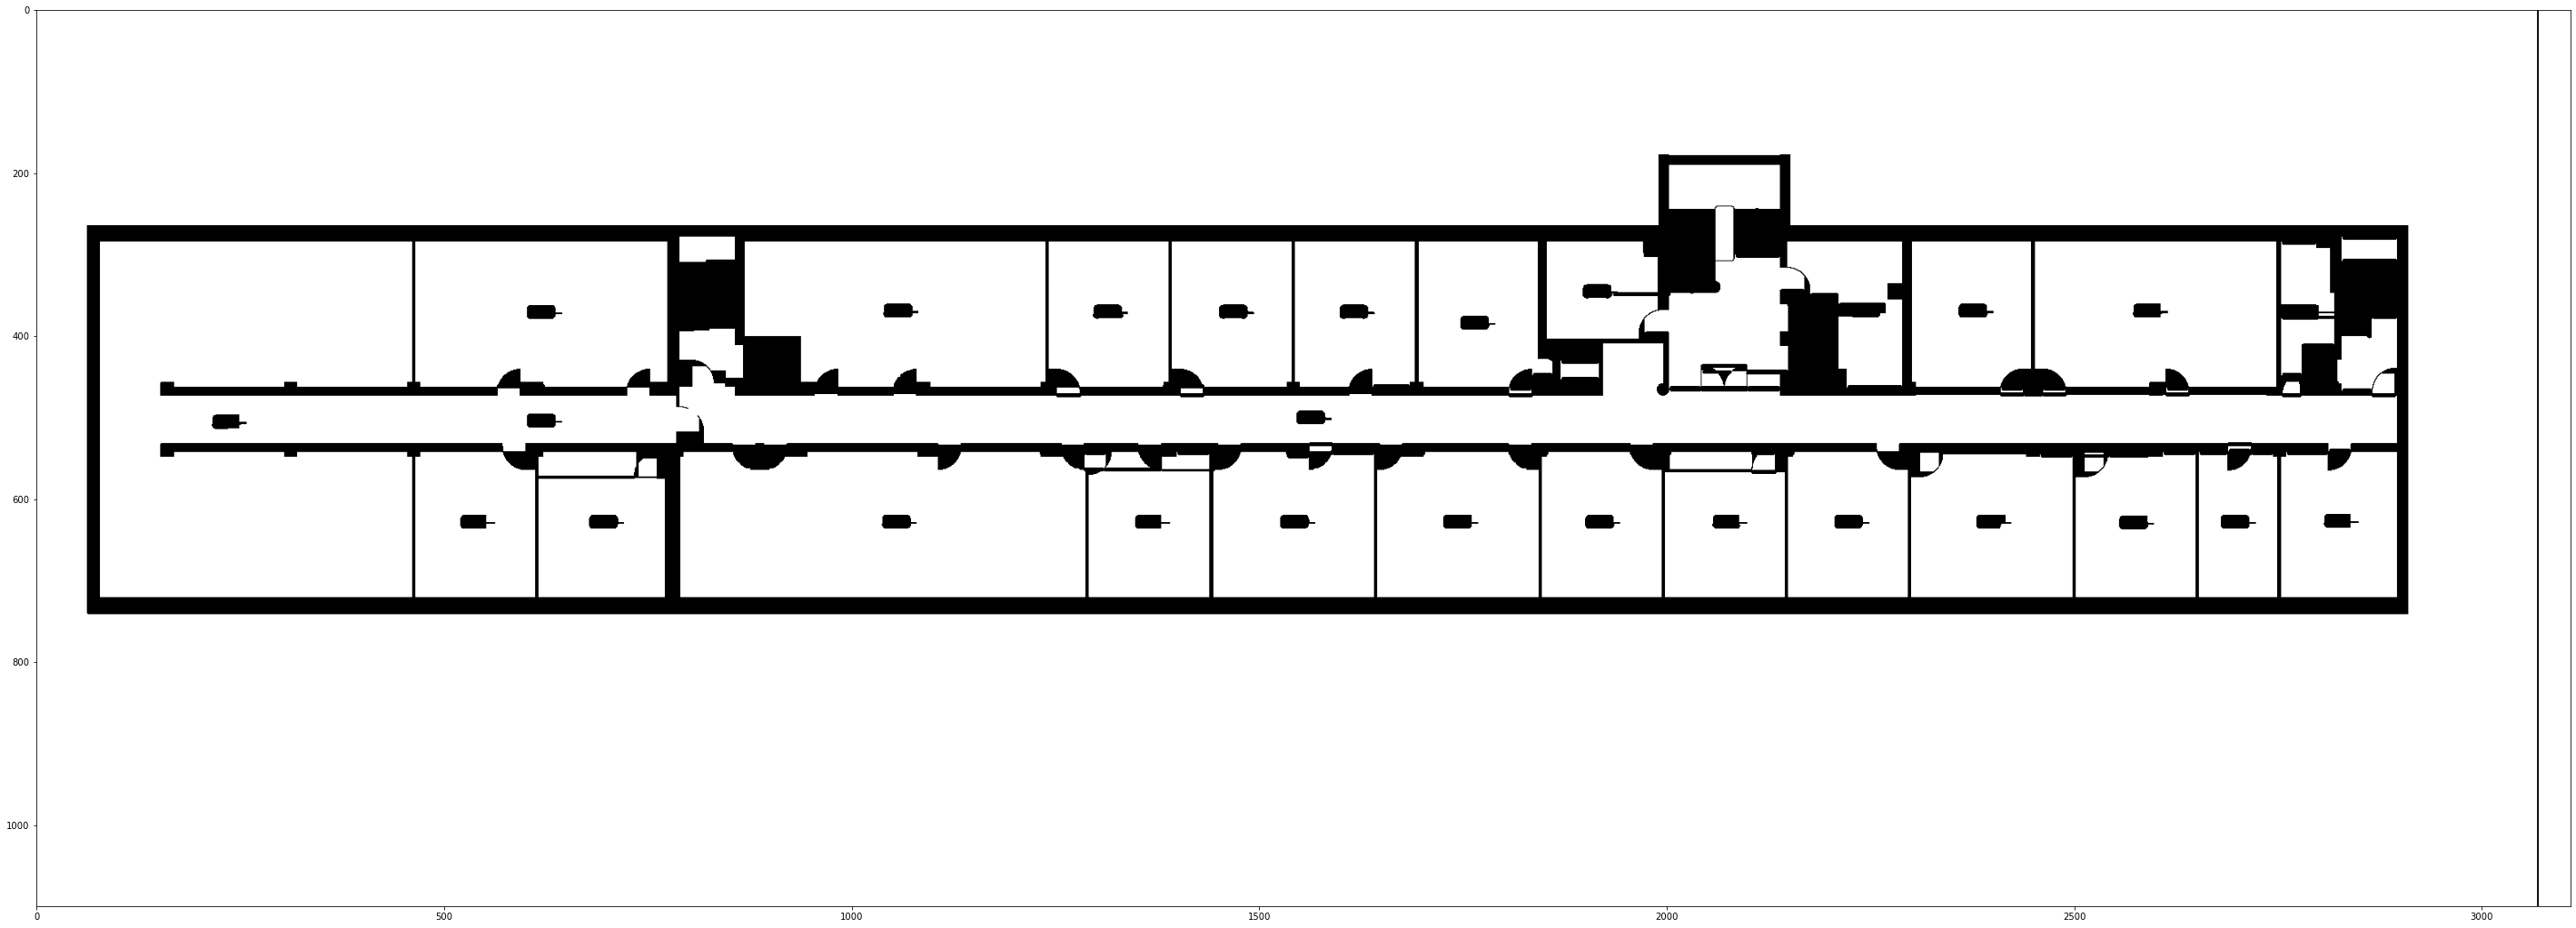

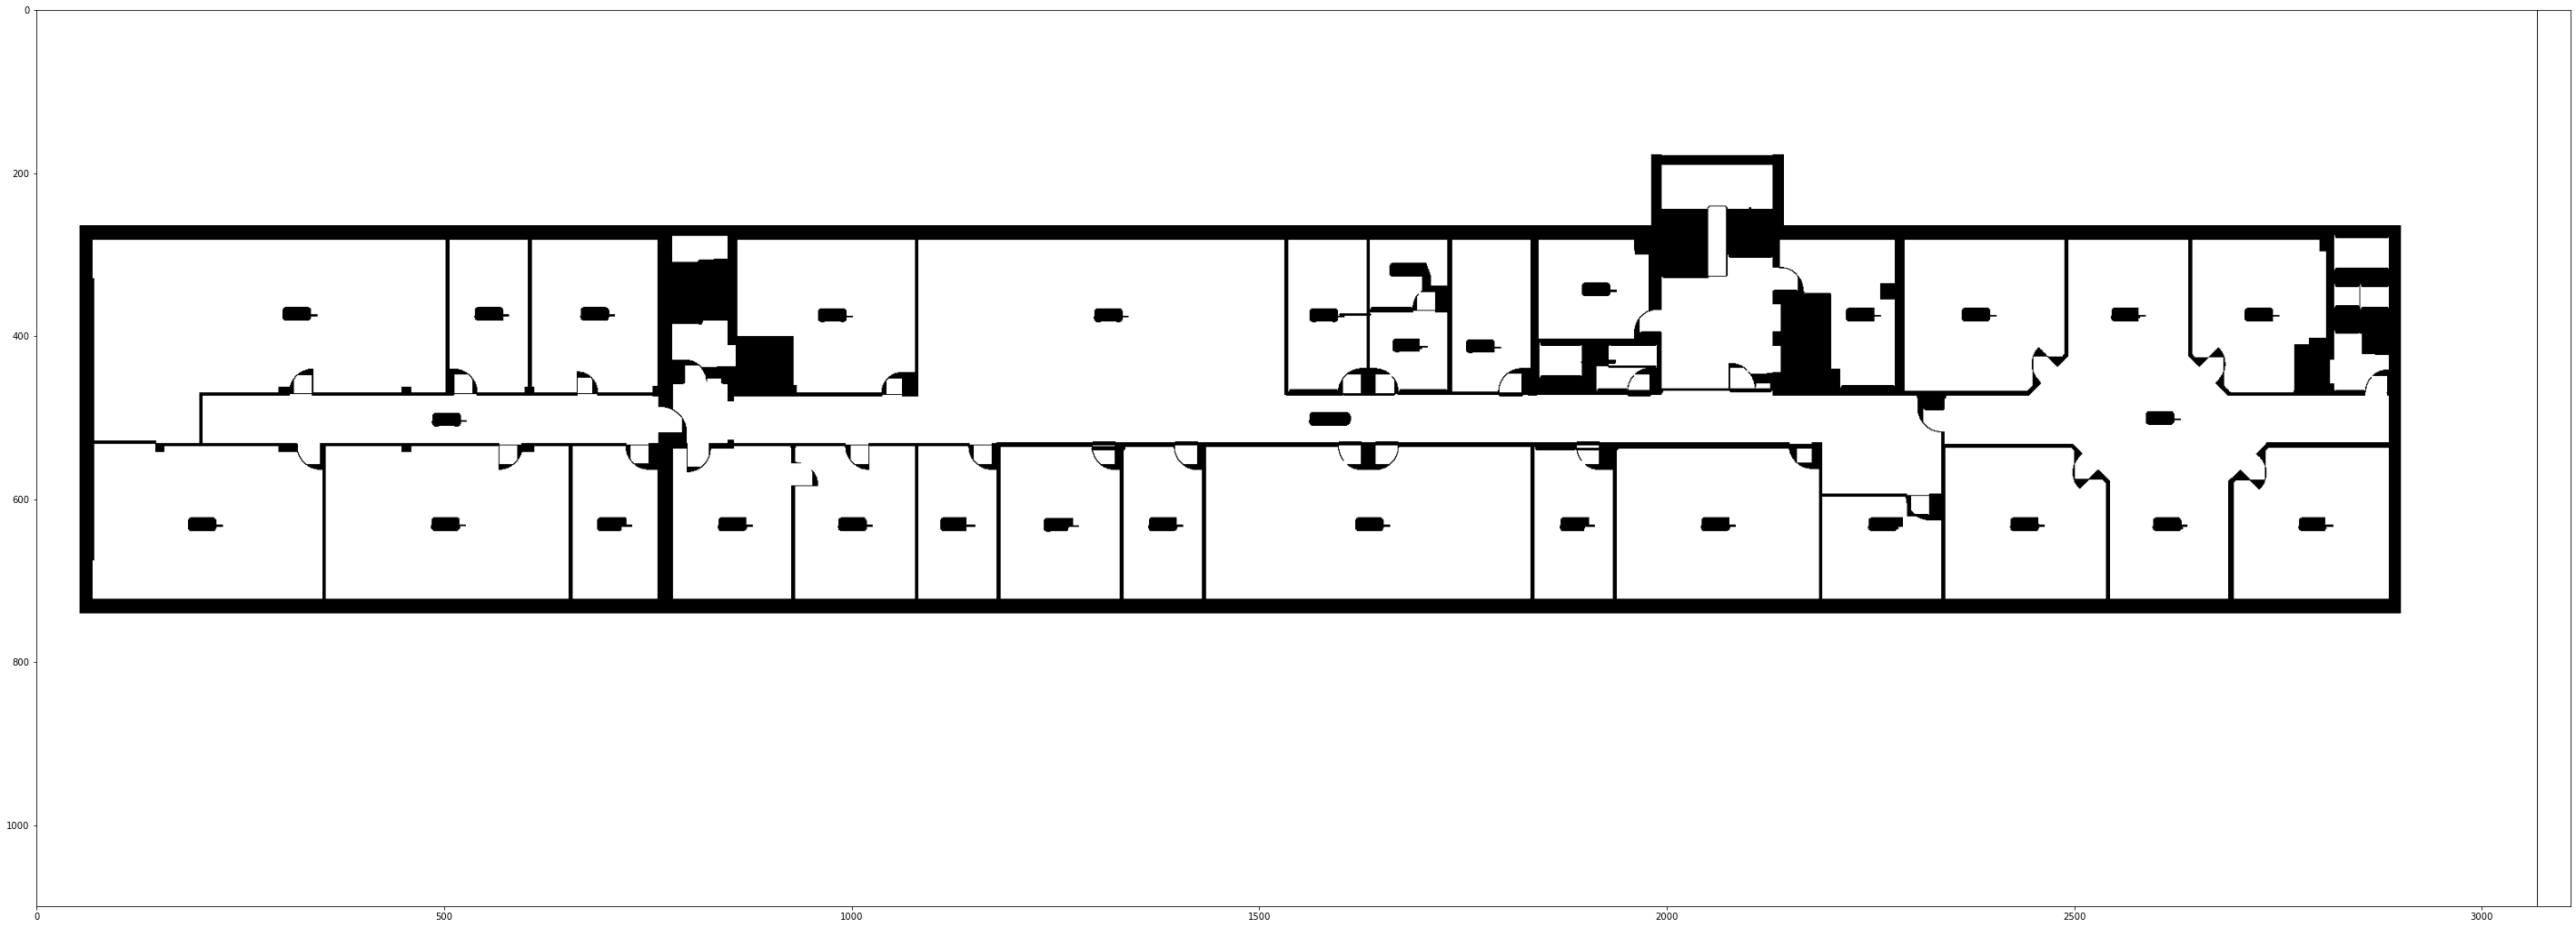

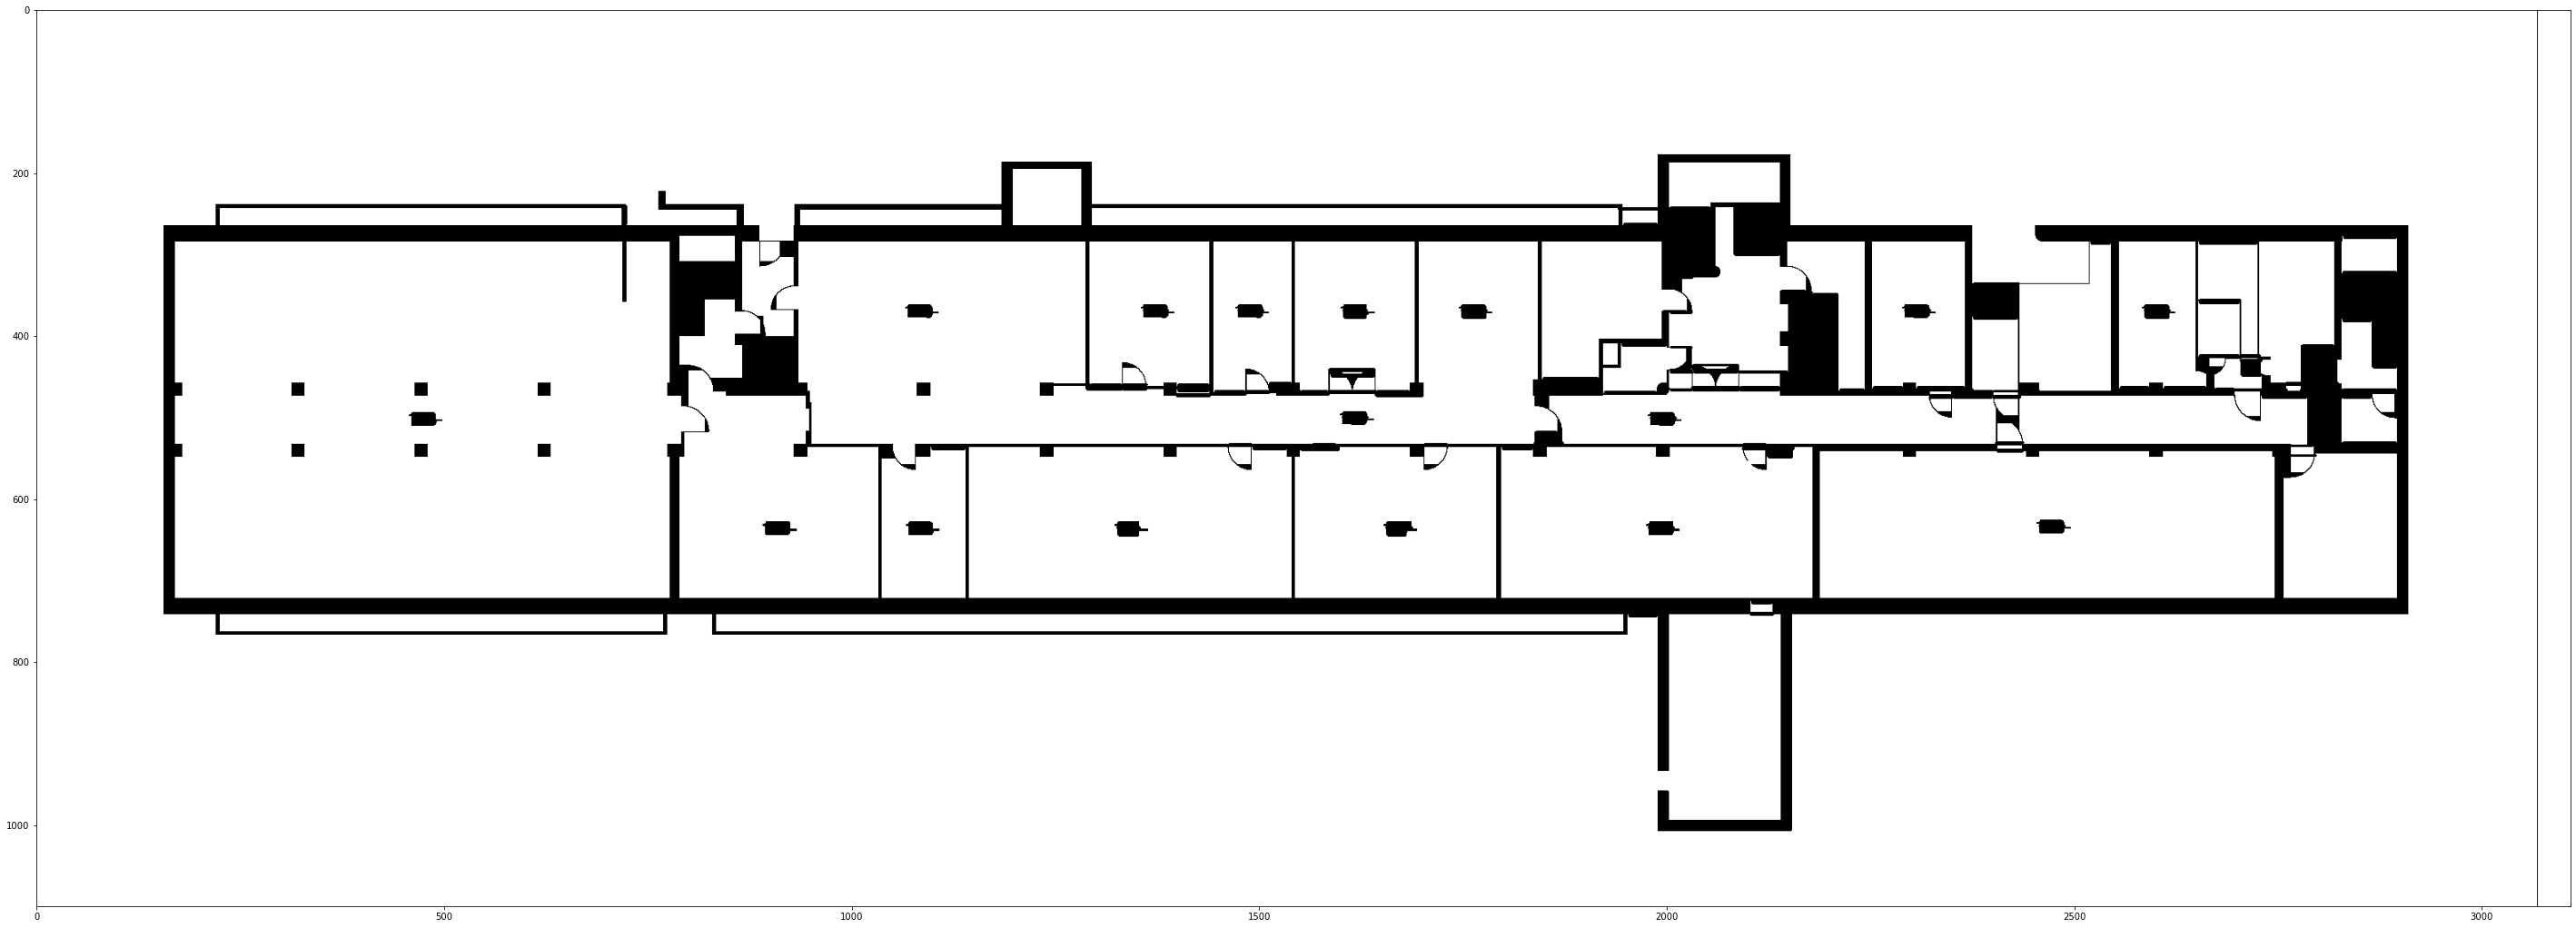

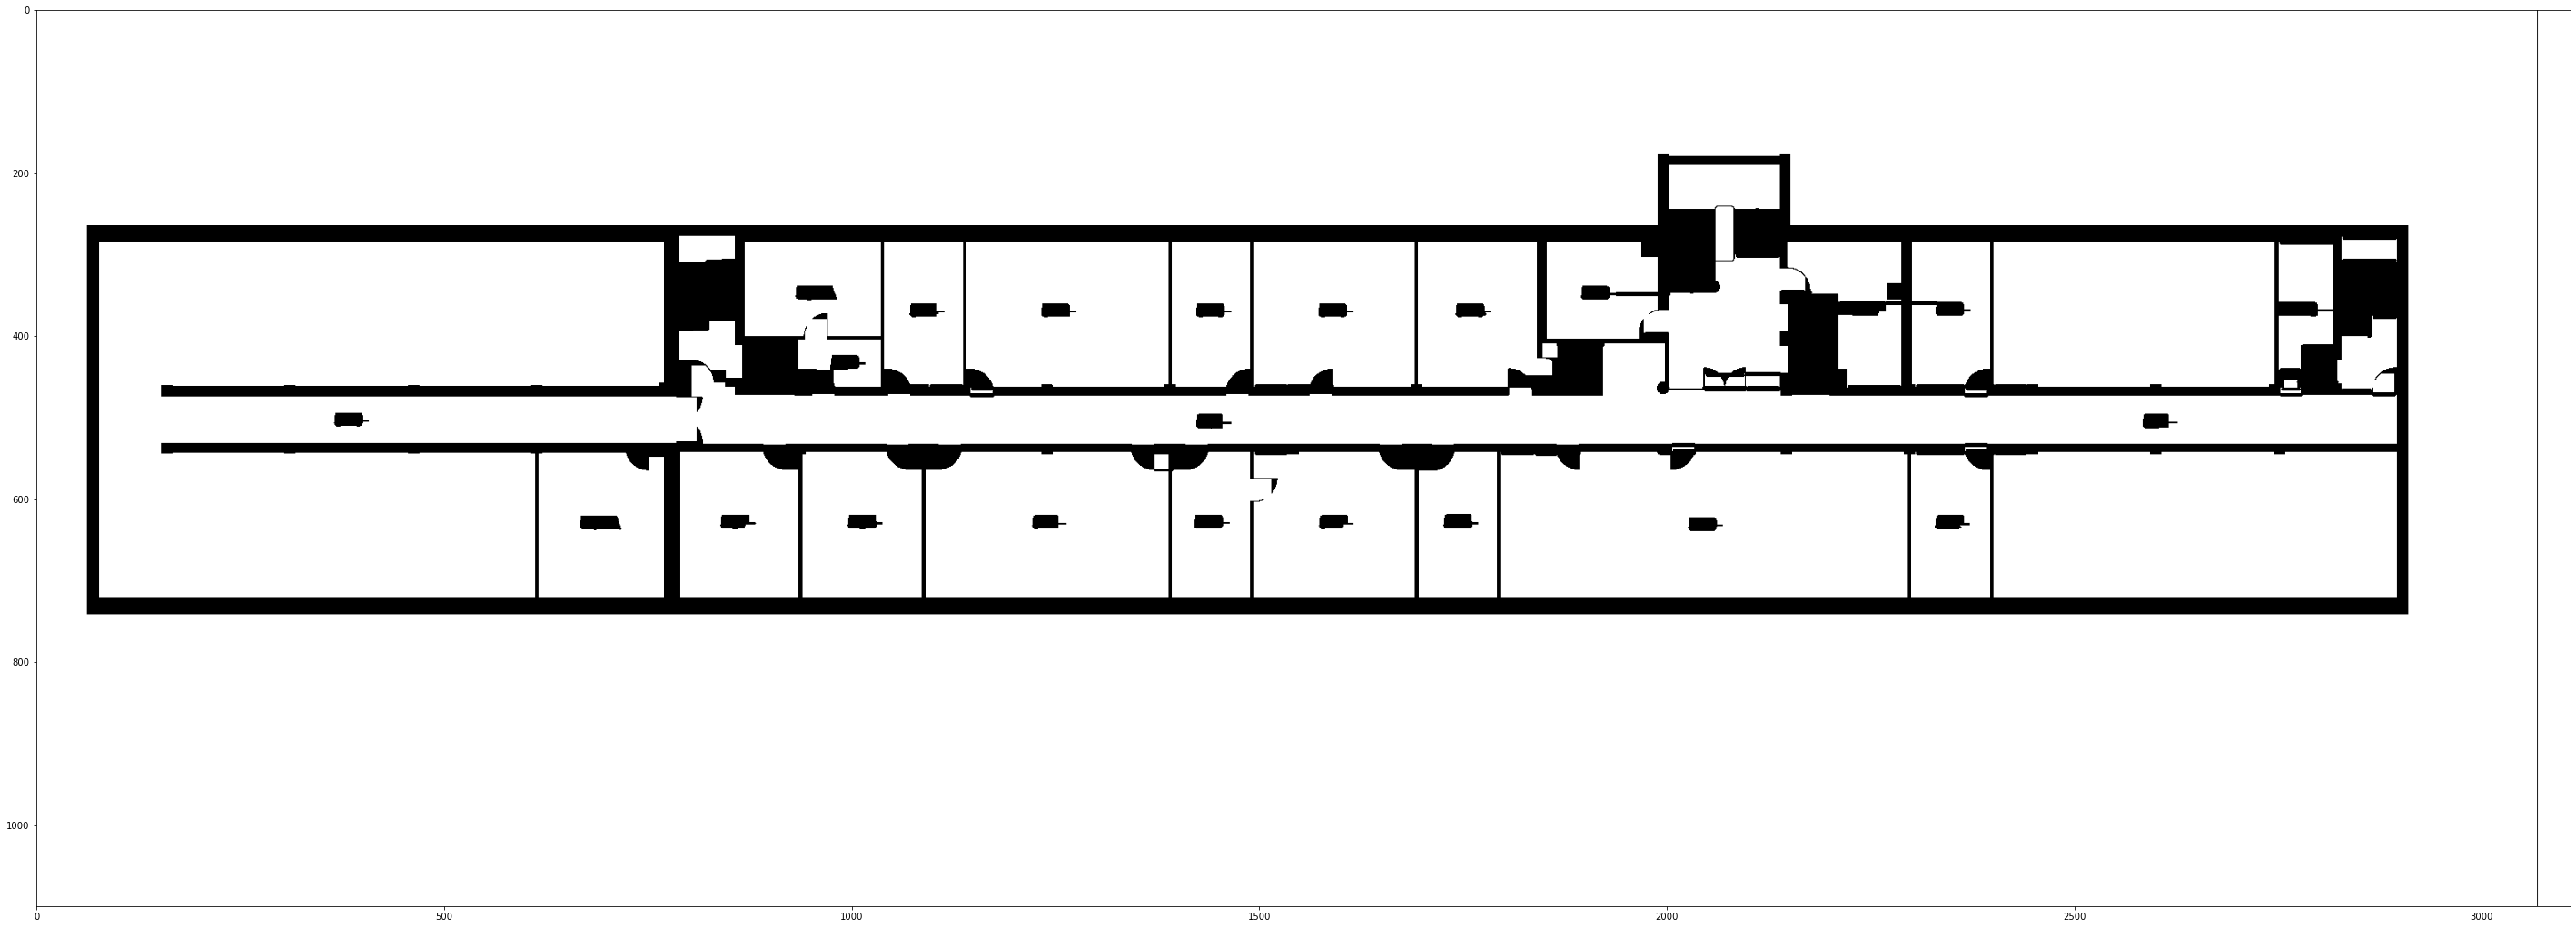

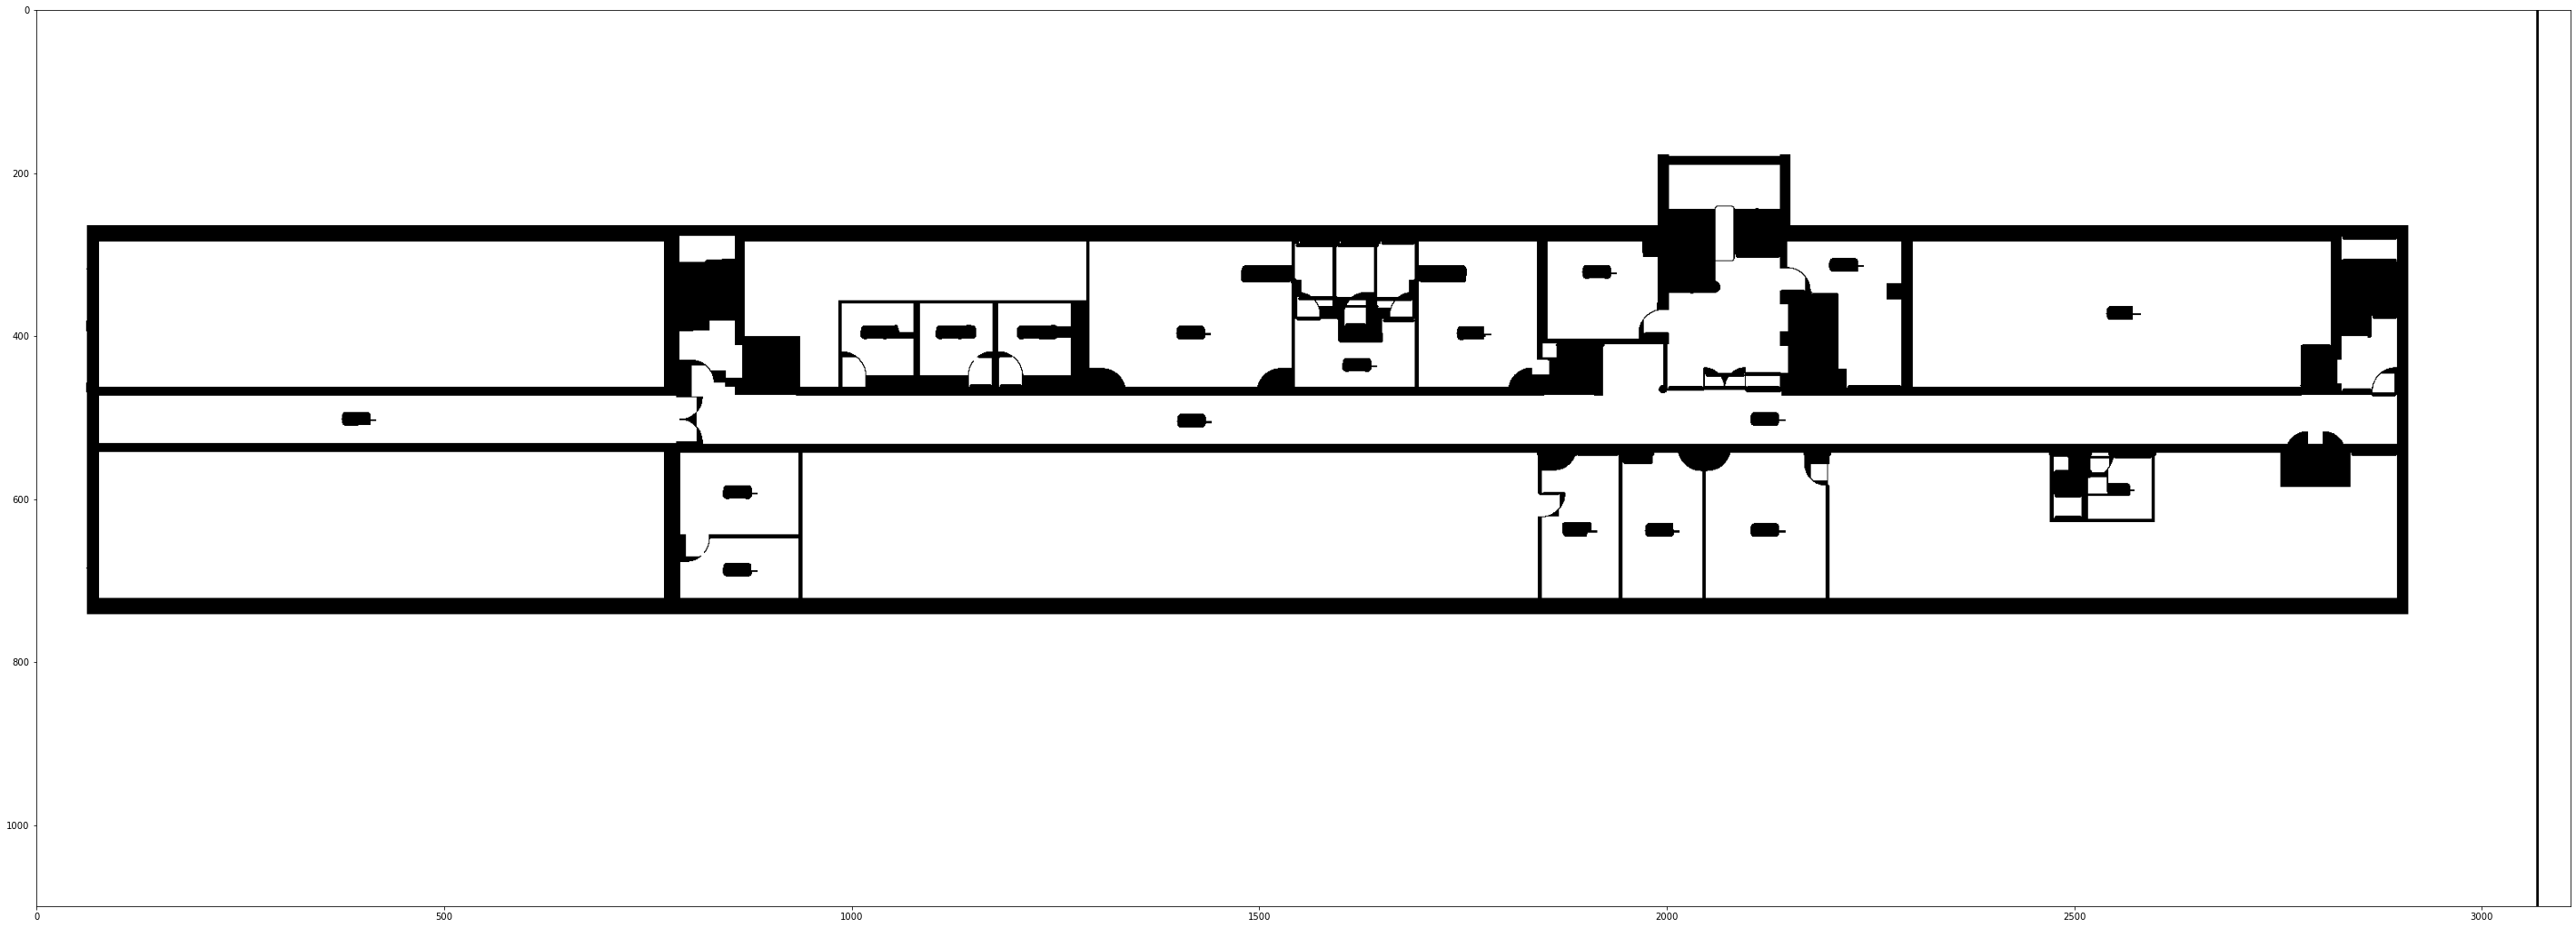

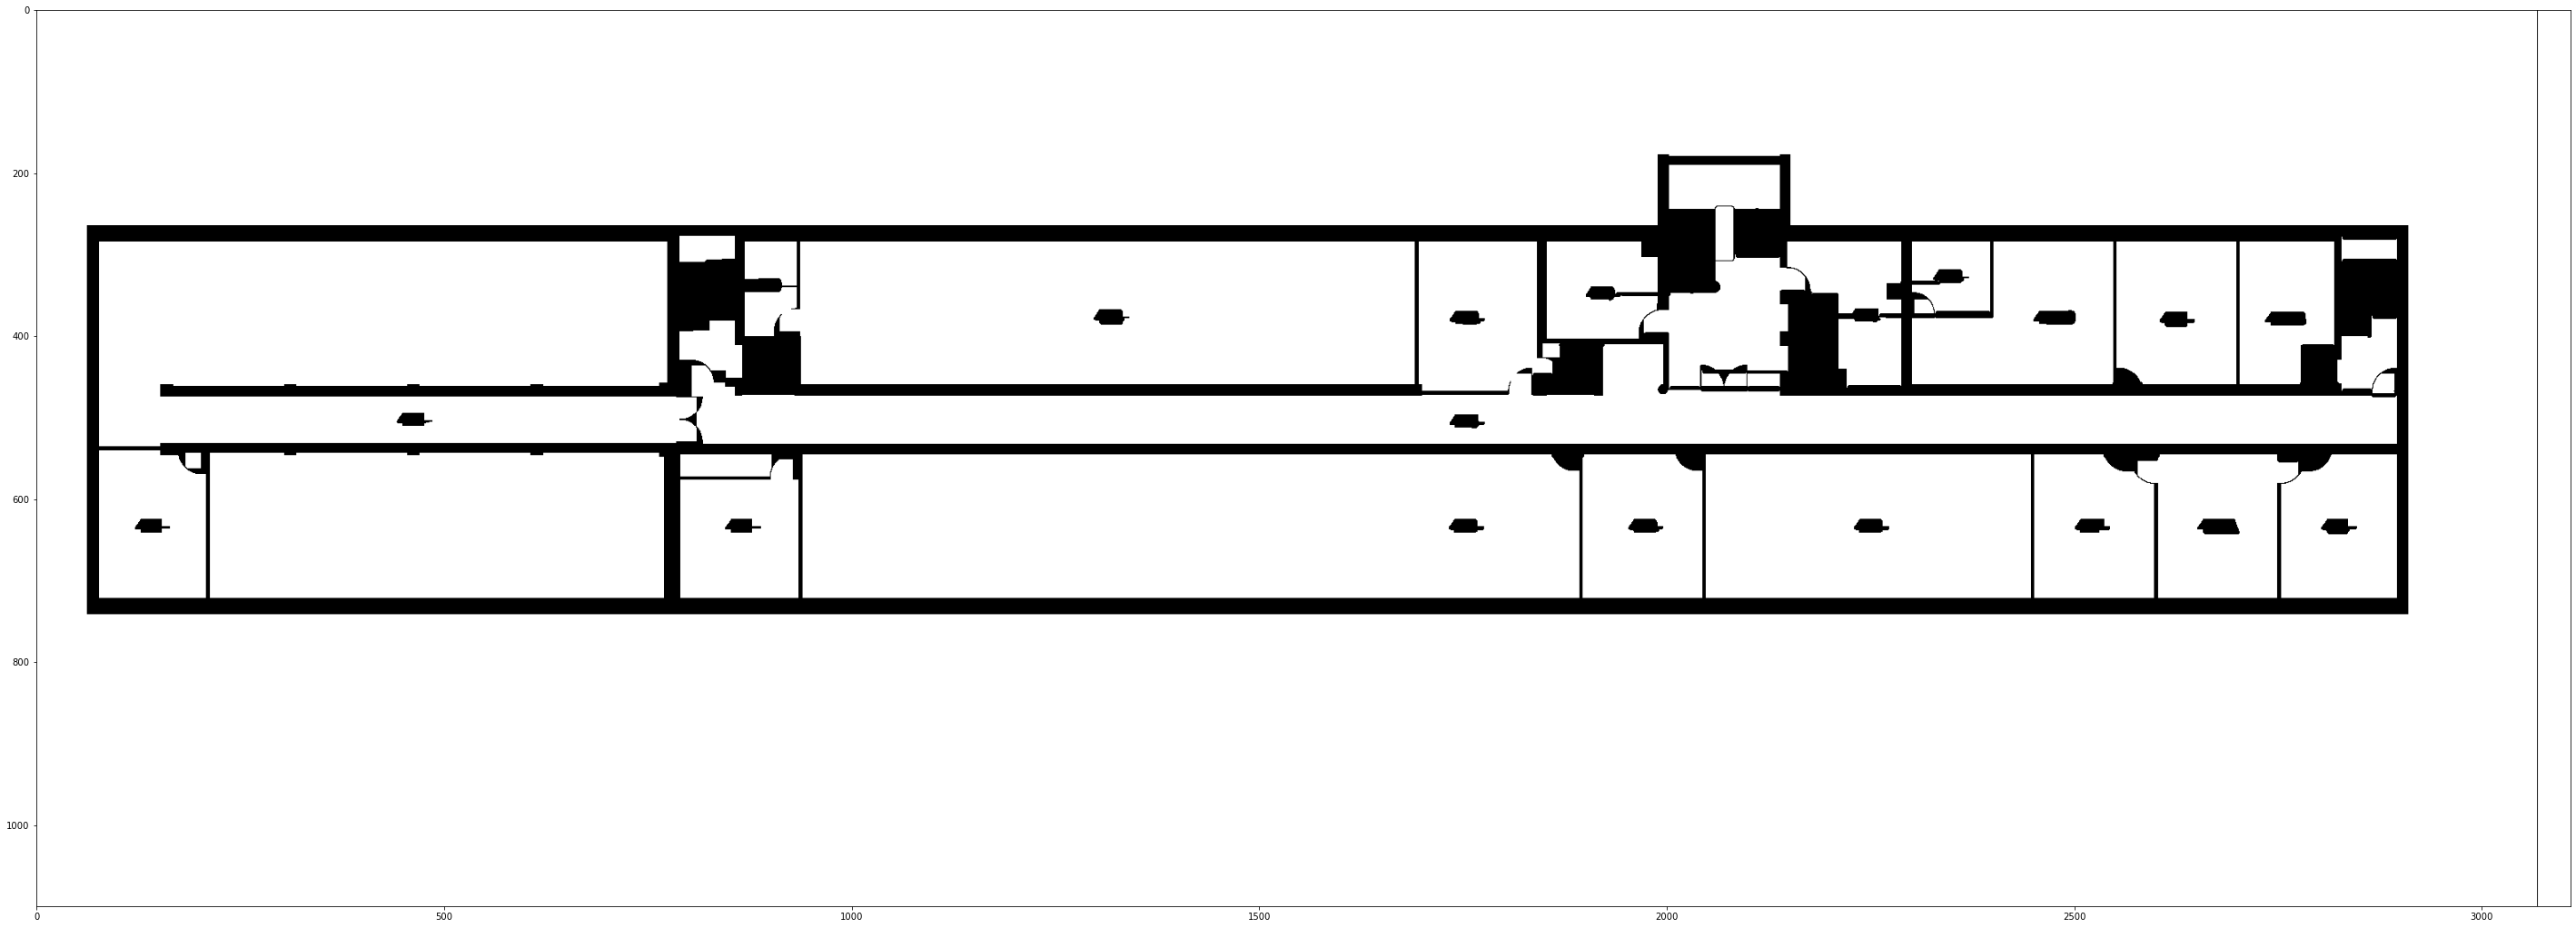

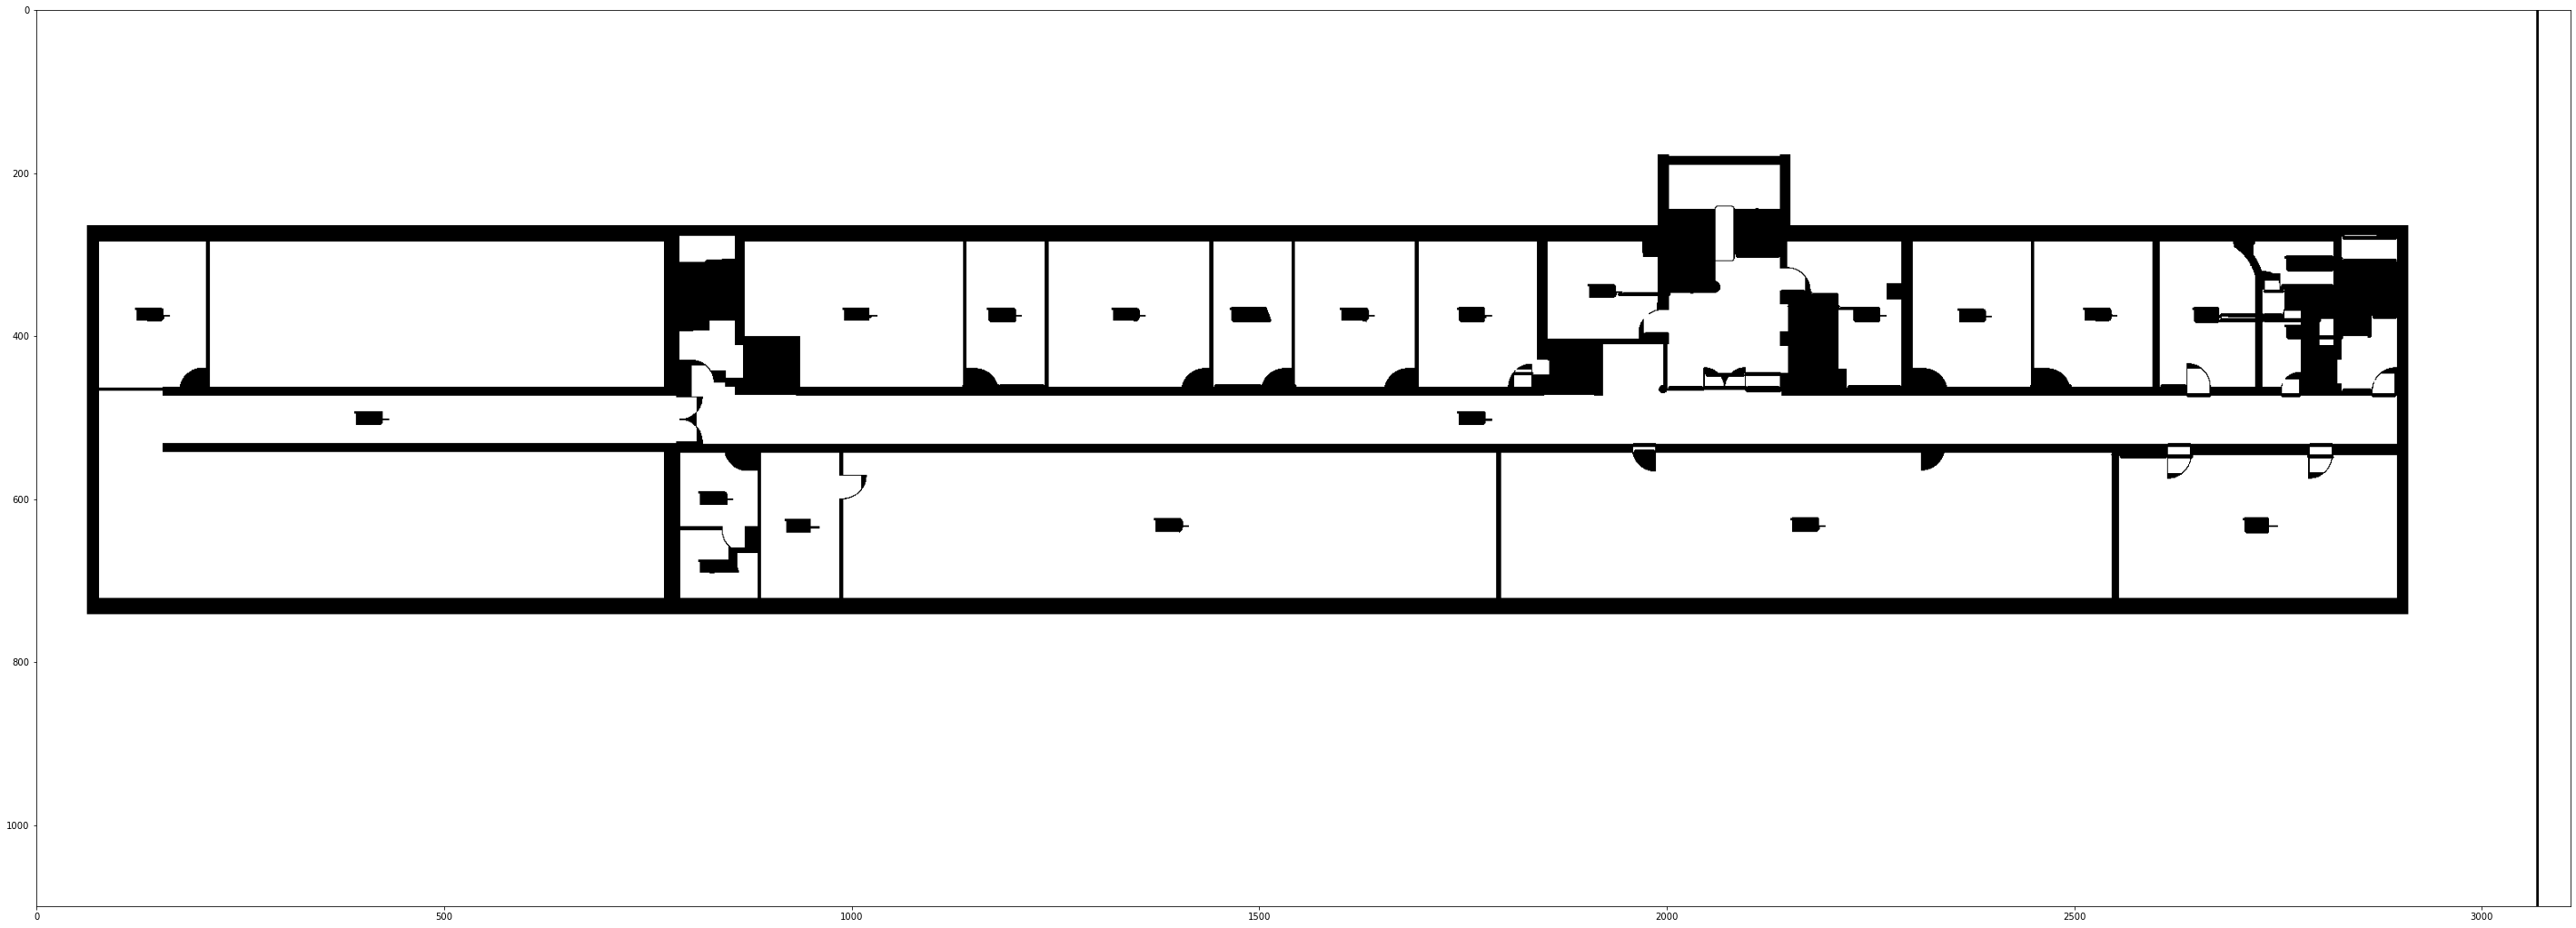

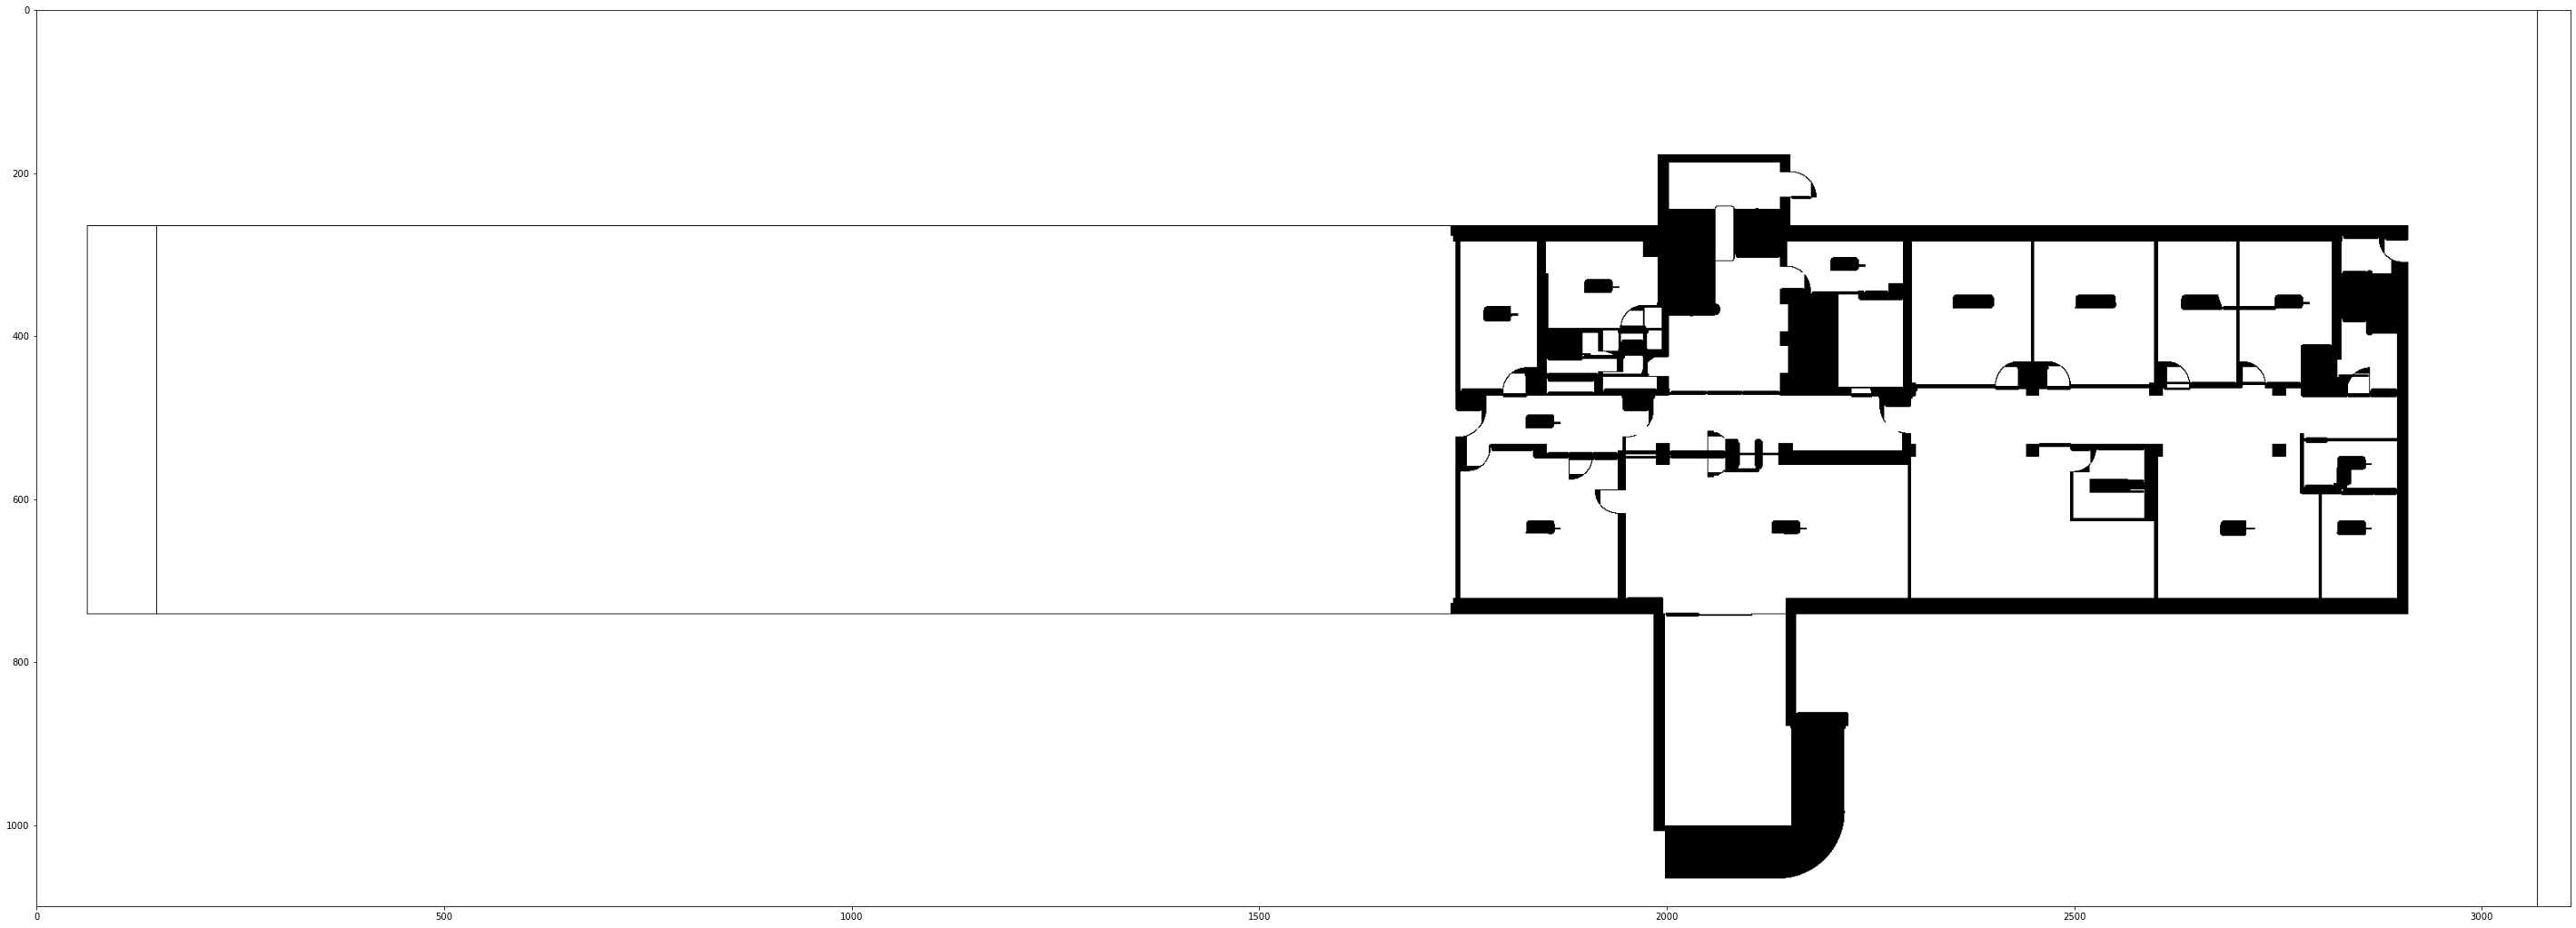

In [9]:
for img_file in img_files:
    plt.figure()
    room, img =  cornerHarris(img_file, mid_show=False)
    plt.imsave("dilated/harris/del_"+img_file, img)

In [63]:



def find_rooms(img, noise_removal_threshold=25, corners_threshold=0.1,
               room_closing_max_length=100, gap_in_wall_threshold=500, show=True):
    """

    :param img: grey scale image of rooms, already eroded and doors removed etc.
    :param noise_removal_threshold: Minimal area of blobs to be kept.
    :param corners_threshold: Threshold to allow corners. Higher removes more of the house.
    :param room_closing_max_length: Maximum line length to add to close off open doors.
    :param gap_in_wall_threshold: Minimum number of pixels to identify component as room instead of hole in the wall.
    :return: rooms: list of numpy arrays containing boolean masks for each detected room
             colored_house: A colored version of the input image, where each room has a random color.
    """
    assert 0 <= corners_threshold <= 1
    # Remove noise left from door removal

    img = cv2.imread("pdf2png/" + img_file,0)
    img_gen_crop = img[600:1700,200:3400]
    img = img_gen_crop
    img = np.where(img > 250, 255, 0).astype(np.uint8)
    contours = cv2.findContours(~img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = contours[0] if len(contours) == 2 else contours[1]
    mask = np.zeros_like(img)
    for contour in contours:
        area = cv2.contourArea(contour)
        if area > noise_removal_threshold:
            cv2.fillPoly(mask, [contour], 255)

    img = ~mask
    if show:
        plt.imshow(img, cmap="gray")
    # Detect corners (you can play with the parameters here)
    dst = cv2.cornerHarris(img ,2, 3, 0.04)
    dst = cv2.dilate(dst,None)
    corners = dst > corners_threshold * dst.max()

    # Draw lines to close the rooms off by adding a line between corners on the same x or y coordinate
    # This gets some false positives.
    # You could try to disallow drawing through other existing lines for example.
    for y,row in enumerate(corners):
        x_same_y = np.argwhere(row)
        print("hi")
        for x1, x2 in zip(x_same_y[:-1], x_same_y[1:]):

            if x2[0] - x1[0] < room_closing_max_length:
                color = np.array([0,0,0])
                img = cv2.line(img, (x1, y), (x2, y), color, 2).astype(np.uint8)

    for x,col in enumerate(corners.T):
        y_same_x = np.argwhere(col)
        for y1, y2 in zip(y_same_x[:-1], y_same_x[1:]):
            if y2[0] - y1[0] < room_closing_max_length:
                color = np.array([0,0,0])
                img = cv2.line(img, (x, y1), (x, y2), color, 2).astype(np.uint8)


    # Mark the outside of the house as black
    contours = cv2.findContours(~img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = contours[0] if len(contours) == 2 else contours[1]
    contour_sizes = [(cv2.contourArea(contour), contour) for contour in contours]
    biggest_contour = max(contour_sizes, key=lambda x: x[0])[1]
    mask = np.zeros_like(mask)
    cv2.fillPoly(mask, [biggest_contour], 255)
    img[mask == 0] = 0

    # Find the connected components in the house
    ret, labels = cv2.connectedComponents(img)
    img = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)
    unique = np.unique(labels)
    rooms = []
    for label in unique:
        component = labels == label
        if img[component].sum() == 0 or np.count_nonzero(component) < gap_in_wall_threshold:
            color = 0
        else:
            rooms.append(component)
            color = np.random.randint(0, 255, size=3)
        img[component] = color

    return rooms, img
